In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from typing import Tuple, Optional

In [32]:
DAYS_PER_YEAR = 365
HOURS_PER_YEAR = 365 * 24
SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds

In [33]:
price = pd.read_feather('BTC-spot.feather')[::24]
price.timestamp = pd.to_datetime(price.timestamp)
price = price.set_index('timestamp')
price = price.spot
returns  = qis.to_returns(prices=price, is_log_returns=True, drop_first=True)


In [34]:
DAYS_PER_YEAR = 365
HOURS_PER_YEAR = 365 * 24
SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds

def index_to_dt(time_index: pd.DatetimeIndex, af: float = DAYS_PER_YEAR) -> np.ndarray:
    dts = (time_index[1:] - time_index[:-1]).total_seconds() / SECONDS_PER_YEAR
    return np.array(dts)


In [35]:
def clip_returns(returns_np: np.ndarray,
                 nu_p: Optional[float],
                 nu_m: Optional[float]
                 ) -> np.ndarray:
    if nu_p is not None and nu_m is not None:
        return np.where(np.logical_and(np.greater(returns_np, nu_m), np.less(returns_np, nu_p)), returns_np, np.nan)
    elif nu_m is not None:
        return np.where(np.greater(returns_np, nu_m), returns_np, np.nan)
    elif nu_p is not None:
        return np.where(np.less(returns_np, nu_p), returns_np, np.nan)
    else:
        return returns_np

In [36]:
def estimate_thresholds(returns: np.ndarray,
                        n: int = 90,
                        low_quantile: float = 0.01,
                        up_quantile: float = 0.45
                        ) -> Tuple[float, float]:
    """
    run a grid search on quantiles of distribution to find lower and upper quantiles
    so that the skewness and kurtosis of mid returns is the closest to zero

    FL: this is somehow different from Hainaut and Embrecht
    """
    qqs = np.linspace(low_quantile, up_quantile, n)
    shift_ms = [np.nanquantile(returns, q) for q in qqs]
    shift_ps = [np.nanquantile(returns, 1-q) for q in qqs]

    func = np.zeros((n, n))
    for n1, shift_m in enumerate(shift_ms):
        for n2, shift_p in enumerate(shift_ps):
            a = np.where(np.logical_and(np.greater(returns, shift_m), np.less(returns, shift_p)), returns, np.nan)
            a = a[np.isnan(a) == False]
            func[n1, n2] = np.abs(skew(a)) + np.abs(kurtosis(a))
            # func[n1, n2] = np.abs(skew(a))
            # func[n1, n2] = np.abs(kurtosis(a))
    ind = np.unravel_index(np.argmin(func, axis=None), func.shape)
    nu_m, nu_p = shift_ms[ind[0]], shift_ps[ind[1]]

    a = np.where(np.logical_and(np.greater(returns, nu_m), np.less(returns, nu_p)), returns, np.nan)
    a = a[np.isnan(a) == False]

    print(f"  quantile for mid returns, ind={ind}, qs=({qqs[ind[0]]:0.4f}, {qqs[ind[1]]:0.4f}),\n",
          f" nu_p={nu_p:0.4f}, nu_m = {nu_m:0.4f},\n", 
          f" skewness without jumps = {skew(a):.4f},\n",
          f" kurtosis without jumps = {kurtosis(a):.4f},\n",
          f" proportion of jump times = {100-(100*len(a)/len(returns)):.4f}%")
    return nu_p, nu_m


In [37]:
nu_p, nu_m = estimate_thresholds(returns=returns)

def infer_jump_times(returns, nu_p, nu_m):
    # returns = qis.to_returns(prices=price, is_log_returns=True, drop_first=True)
    # estimate thresholds
    positive_jumps_path = np.where(returns >= nu_p, returns, 0)
    negative_jumps_path = np.where(returns <= nu_m, returns, 0)
    # print(nu_p, nu_m)
    return positive_jumps_path, negative_jumps_path

  quantile for mid returns, ind=(9, 7), qs=(0.0545, 0.0446),
  nu_p=0.0668, nu_m = -0.0580,
  skewness without jumps = 0.0153,
  kurtosis without jumps = -0.0033,
  proportion of jump times = 9.9386%


In [38]:
positive_jumps_path, negative_jumps_path = infer_jump_times(returns, nu_p, nu_m)
_id = returns > nu_m
_id*= returns < nu_p
diffusion = returns[_id]

print(positive_jumps_path[(positive_jumps_path !=0)].mean(), negative_jumps_path[(negative_jumps_path !=0)].mean())
print((positive_jumps_path !=0).sum(), (negative_jumps_path !=0).sum())

0.09620184646215557 -0.09529482506387064
117 142


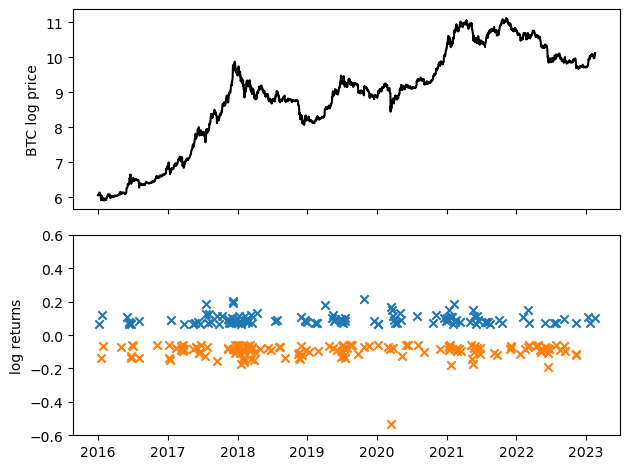

In [39]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(np.log(price), c='black')
ax[0].set_ylabel('BTC log price')

_id = positive_jumps_path != 0
ax[1].scatter(returns.index[_id], positive_jumps_path[_id], marker='x')

_id = negative_jumps_path != 0
ax[1].scatter(returns.index[_id], negative_jumps_path[_id], marker='x')
ax[1].set_ylim(-.6,.6)
ax[1].set_ylabel('log returns')

plt.tight_layout()
plt.savefig('BTC_timeseries_jumps.png', transparent=True)


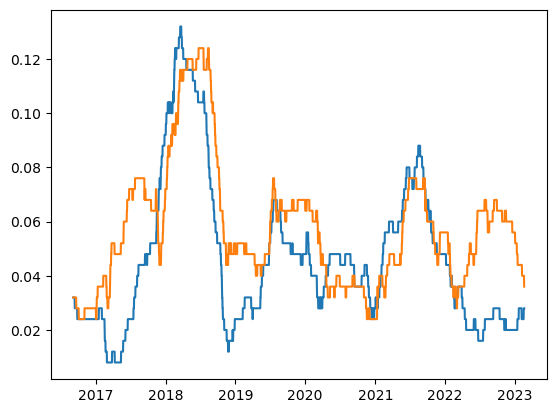

In [40]:
window = 250

positive_jump_indicator = pd.Series(positive_jumps_path!=0, index=returns.index)
plt.plot(positive_jump_indicator.rolling(window, min_periods=window).sum()/window)

negative_jump_indicator = pd.Series(negative_jumps_path!=0, index=returns.index)
plt.plot(negative_jump_indicator.rolling(window, min_periods=window).sum()/window)

# plt.savefig('jump_counts_rolling_sum_window_%i.png'%window, transparent=True)
# plt.savefig('jump_intensities_rolling_sum_window_%i.png'%window, transparent=True)

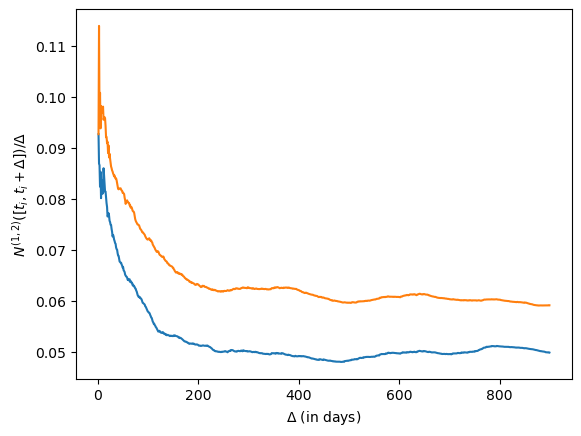

In [41]:
positive_jumps_intensity_arr = []
negative_jumps_intensity_arr = []
window_arr = range(1,900)

# Jump times id
_id = ( (positive_jumps_path != 0) + (negative_jumps_path != 0 ) ) != 0

for window in window_arr:
    positive_jumps_intensity = positive_jump_indicator.rolling(window).sum().shift(-window)/window
    positive_jumps_intensity = np.nanmean(positive_jumps_intensity.loc[_id])

    negative_jumps_intensity = negative_jump_indicator.rolling(window).sum().shift(-window)/window
    negative_jumps_intensity = np.nanmean(negative_jumps_intensity.loc[_id])

    positive_jumps_intensity_arr.append(positive_jumps_intensity)
    negative_jumps_intensity_arr.append(negative_jumps_intensity)

plt.plot(window_arr, positive_jumps_intensity_arr)
plt.plot(window_arr, negative_jumps_intensity_arr)
plt.ylabel(r'$N^{(1,2)}\left([t_i, t_i +\Delta ]\right)/\Delta$')
plt.xlabel(r'$\Delta$ (in days)')
plt.savefig('kernel.png', transparent=True)